# Plot results for Aintelope
Run these blocks for all tests, then scroll to the title you're interested in:


In [1]:
%%capture
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath

from torch import Tensor

import dateutil.parser as dparser
import sys
import os

import seaborn as sns

from aintelope.training.lightning_trainer import DQNLightning
from aintelope.agents.memory import ReplayBuffer
import aintelope.agents
from aintelope.agents import get_agent_class
#from aintelope.agents.inference_agent import InferenceAgent
from aintelope.environments.savanna_gym import SavannaGymEnv
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
import hydra
from hydra.core import global_hydra

In [2]:
root_dir = os.path.split(os.path.split(os.getcwd())[0])[0]

if root_dir not in sys.path:
    sys.path.append(root_dir)

In [ ]:
outputs_dir = root_dir+'/outputs/' 
available_records = os.listdir(outputs_dir)
print("Existing training runs", available_records)

dirs = [os.path.join(outputs_dir, f) for f in available_records] # add path to each file
dirs.sort(key=lambda x: os.path.getmtime(x))
assert len(dirs) > 0, "No trainings have been run! make run-training* first"

# sort by experiment type (baseline/instinct) 
global_hydra.GlobalHydra.instance().clear()
with initialize(version_base=None, config_path="../config"):
    #conf_dir = root_dir+'/aintelope/config/config_experiment.yaml'
    conf_dir = 'config_experiment.yaml'
    cfg = compose(config_name=conf_dir, overrides=[])  #OmegaConf.load(conf_dir) 
    cfg_base = compose(config_name=conf_dir, overrides=["hparams.agent_id=q_agent","hparams.agent_params.target_instincts=[]"])
    cfg_inst = compose(config_name=conf_dir, overrides=["hparams.agent_id=instinct_agent","hparams.agent_params.target_instincts=['smell']"])

models = {}
for exp_dir in dirs:
    dirr = "../../outputs/"+exp_dir.split('/')[-1]+"/hydra_logs/.hydra"
    #print(exp_dir)
    with initialize(version_base=None, config_path=dirr): #"../config"
        conf_dir = 'config.yaml'
        cfg = compose(config_name=conf_dir, overrides=[])
    mode = cfg.hparams.agent_id
    #print(mode)
    mod_dir = os.listdir(exp_dir+"/checkpoints/")
    runs_dir = [os.path.join(exp_dir+"/checkpoints/", m) for m in mod_dir]
    runs_dir.sort(key=lambda x: os.path.getmtime(x))
    if mode not in models:
        models[mode] = []
    models[mode].append(runs_dir)
#print(models)

# Old plots

In [ ]:
latest_exp_dir = dirs[0]
print(latest_exp_dir)
print(dparser.parse(latest_exp_dir,fuzzy=True))
df = pd.read_csv(latest_exp_dir+"/memory_records.csv")
print(df.columns)

In [ ]:
%%capture
'''
WIP, plot what the agent sees (needs changes to InferenceAgent etc.)
Check action values per location. Now expected reward for moving into location, but could also be
eating in any location, or of course mapping where the food/agents are. 
'''
#cfg = OmegaConf.load(conf_dir_base)

# load environment agent
env = SavannaGymEnv(env_params=cfg.hparams.env_params)
env.reset() #this is also init...
# get the brains from memory checkpoints
model = DQNLightning.load_from_checkpoint(latest_exp_dir+"/checkpoints/last.ckpt")
# disable randomness, dropout, etc...
model.eval()

In [ ]:
from collections import namedtuple

keys = (["agent_coords"] + 
        [f"grass_patch_{i}" for i in range(env.metadata["amount_grass_patches"])] + 
        [f"water_hole_{i}" for i in range(env.metadata["amount_water_holes"])])
StateTuple = namedtuple("StateTuple", {k: np.ndarray for k in keys})

x = []
y = []
event_x = []
event_y = []
event_type = []
food_x = []
food_y = []
water_x = []
water_y = []
for _ ,row in df.iterrows():
    
    state = eval(row['state'])
    #print(state)
    x.append(state[0][0])
    y.append(state[0][1])
    
    #refactor
    food_x.append(state[1][0])
    food_y.append(state[1][1])
    #food_x.append(state[2][0])
    #food_y.append(state[2][1])    

    if row['instinct_events'] != '[]':
        event_x.append(x[-1])
        event_y.append(y[-1])
        event_type.append(row['instinct_events'])

In [ ]:
agent_df = pd.DataFrame(data={'x':x, 'y':y})
print(agent_df.head(), len(agent_df))

food_df = pd.DataFrame(data={'x':food_x, 'y':food_y})
print(food_df.head(), len(food_df))

#water_df = pd.DataFrame(data={'x':water_x, 'y':water_y})
#print(water_df.head(), len(water_df))

In [ ]:
event_df = pd.DataFrame(data={'x':event_x, 'y':event_y, 'event_type':event_type})
print(len(event_df))
print(event_df.head())

In [ ]:
plt.plot(agent_df['x'], agent_df['y'], '.r-')
plt.plot(food_df['x'], food_df['y'], '.g', markersize=15)
#plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

In [ ]:
# plot reward received over time
df['reward'].plot()


In [ ]:
color_map = 'autumn' # starts yellow, goes orange, then red
n_points = len(agent_df)

fig = plt.figure()
ax1 = fig.add_subplot(111) 
cm = plt.get_cmap(color_map)
for i in range(10):
    ax1.set_prop_cycle('color', cm(np.linspace(0, 1, n_points - 1, endpoint=False)))
    for i in range(n_points - 1):
        plt.plot(agent_df['x'][i:i+2], agent_df['y'][i:i+2])
plt.plot(food_df['x'], food_df['y'], '.g', markersize=15)
#plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

# Valuemaps for actions
Note, these maps are new ones and don't correlate with the above ones as we randomly regenerate them.

In [ ]:
%%capture
'''
WIP, plot what the agent sees (needs changes to InferenceAgent etc.)
Check action values per location. Now expected reward for moving into location, but could also be
eating in any location, or of course mapping where the food/agents are. 
'''
#cfg = OmegaConf.load(conf_dir)

# load environment agent
env = SavannaGymEnv(env_params=cfg.hparams.env_params)
env.reset() #this is also init...
# get the brains from memory checkpoints
model = DQNLightning.load_from_checkpoint(latest_exp_dir+"/checkpoints/last.ckpt")
# disable randomness, dropout, etc...
model.eval()

In [ ]:
# move the agent into each square and ask for its values for each action, then add that direction into the map
valuemap = np.zeros((env.metadata['map_max']+2,env.metadata['map_max']+2,4))
agent = env.agents[0]

ACTION_MAP = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]]) # This is a copy from savanna.py, should be an accessible param
for x in range(0, env.metadata['map_max']):
    for y in range(0, env.metadata['map_max']):
        if (env.grass_patches == [x,y]).all(1).any():
            continue
        if (env.water_holes == [x,y]).all(1).any():
            continue
        env.set_agent_position(agent, np.array([x,y]))
        observation = env.observe(agent)
        #print(env.agent_states[agent])
        action_vals = model(Tensor(observation)).detach().numpy()
        offset = ACTION_MAP
        for action in range(len(ACTION_MAP)):
            x_ = offset[action][0]+x
            y_ = offset[action][1]+y
            valuemap[x_,y_,action] = action_vals[action]
            
valuemap = np.sum(valuemap,2)/len(ACTION_MAP)

#print(valuemap)

In [ ]:
sns.heatmap(valuemap[1:-1,1:-1])

In [ ]:
#env.render() isnt working atm
maps = np.zeros((env.metadata['map_max'],env.metadata['map_max']))
for grs in env.grass_patches:
    print(grs[0])
    maps[int(grs[0]),int(grs[1])] = 2.0
for wtr in env.water_holes:
    maps[int(wtr[0]),int(wtr[1])] = 4.0
sns.heatmap(maps)
# RED FOOD, LIGHT water

In [ ]:
env.set_agent_position(agent, np.array([2,2]))
observation = env.observe(agent)
action_vals = model(Tensor(observation)).detach().numpy()
print(action_vals)

# Model performance plots
These plots don't have the exploration bonus as confabulators (such as epsilon-greedy).

Train the model N times, then change n_latest to this N and run the block.

In [4]:
# Run each model for 10 different resets, with 10 different locations on the map.
# Gather the cumulative reward, -1 has to be given on each step though
# reset each time the food is found
def testrun(model,env,cfg, samples, test_length):
    agent = get_agent_class(cfg.hparams.agent_id)(
        env,
        ReplayBuffer(cfg.hparams.replay_size),
        0,
        cfg.hparams.agent_params,
    )
    epsilon = 0.0
    device = "cpu"
    coords = np.arange(env.metadata['map_min'], env.metadata['map_max'], 1)
    start_pos = np.random.choice(coords, size=(samples,2))
    scores = []
    rewards = []
    for j in range(start_pos.shape[0]):
        agent.reset() # !!!
        env.set_agent_position(agent, np.array(start_pos[j]))
        for i in range(test_length):
            reward, score, done = agent.play_step(model, epsilon, device) # !!!
            rewards.append(reward) 
            scores.append(score)
            
    return scores, rewards, agent


In [5]:
%%capture
# Load the models from checkpoints and run them through test envs to measure their performance 
# without training parameters (usually exploration, like epsilon). statistical significance per run
def calc_results_per_model(models, test_cfg): #test_dirs
    '''
    models = []
    for exp_dir in test_dirs:
        mod_dir = os.listdir(exp_dir+"/checkpoints/")
        runs_dir = [os.path.join(exp_dir+"/checkpoints/", m) for m in mod_dir]
        runs_dir.sort(key=lambda x: os.path.getmtime(x))
        models.append(runs_dir)
    '''    
    samples = 10 # how many times a random start location is attempted
    test_length = 20 # how long time to find grass
    
    env = SavannaGymEnv(env_params=test_cfg.hparams.env_params)
    scores = np.zeros([len(models[0]),len(models),samples*test_length]) 
    rewards = np.zeros([len(models[0]),len(models),samples*test_length])
    for i in range(len(models)): # different runs for statistical significance
        for j in range(len(models[0])): # model as epochs progress
            model = DQNLightning.load_from_checkpoint(models[i][j]).net
            model.eval()
            # run model
            score, reward, agent = testrun(model, env, test_cfg, samples, test_length)
            scores[j,i,:] = score
            rewards[j,i,:] = reward
    return scores, rewards, agent

In [6]:
%%capture
# Style | epoch x 4-corners x repetition
# Two np arrays with [10,4,10] dimensions 
# Style=baseline or instinct, 4-corners is in above the different starting positions 
# (i.e. statistical stability) and repetitions is for all the folders ya made, (stat stab)

# Split directories here for which ones in outputs are from instinct and which are baseline
base_dirs = models['q_agent']
inst_dirs = models['instinct_agent']

b_scores, b_rewards, b_agent = calc_results_per_model(base_dirs, cfg_base)
i_scores, i_rewards, i_agent = calc_results_per_model(inst_dirs, cfg_inst)

In [29]:
def combine_dims(a, start=0, count=2):
    """ Reshapes numpy array a by combining count dimensions, 
        starting at dimension index start """
    s = a.shape
    return np.reshape(a, s[:start] + (-1,) + s[start+count:])

print(b_scores.shape, b_rewards.shape)
print(i_scores.shape, i_rewards.shape)

b_s = combine_dims(b_scores[0:-1,:,:],1).T
b_r = combine_dims(b_rewards[0:-1,:,:],1).T
i_s = combine_dims(i_scores[0:-1,:,:],1).T
i_r = combine_dims(i_rewards[0:-1,:,:],1).T

(11, 10, 200) (11, 10, 200)
(11, 10, 200) (11, 10, 200)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10,) (2000, 10)


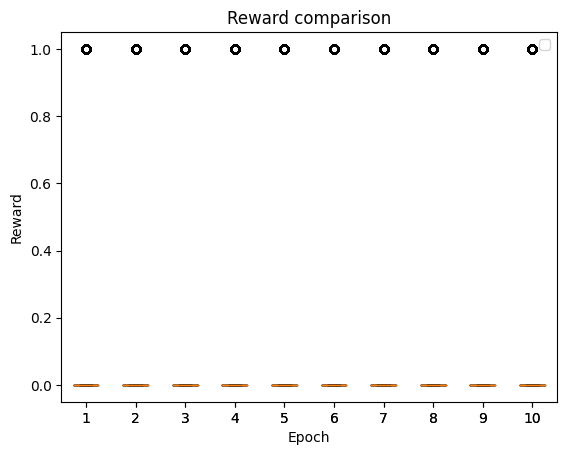

In [31]:
# Plot results
X = np.arange(1, b_scores[:-1,].shape[0]+1) 
print(X.shape, b_r.shape)
#plt.plot(X, b_r, color='r', label='baseline') 
#plt.plot(X, i_r, color='g', label='instinct') 
plt.boxplot(b_r, labels=X)
plt.boxplot(i_r, labels=X)

plt.xlabel("Epoch") 
plt.ylabel("Reward") 
plt.title("Reward comparison") 
plt.legend() 
plt.show() 

In [ ]:
# Add statsign boxes
# figure out what the rewards should be from agent
# figure out what the score should be
# do 10 epochs
# https://matplotlib.org/3.1.1/gallery/statistics/boxplot.html

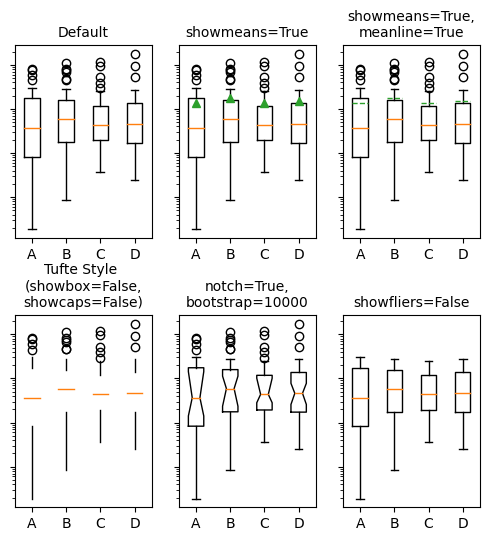

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# fake data
np.random.seed(19680801)
data = np.random.lognormal(size=(37, 4), mean=1.5, sigma=1.75)
labels = list('ABCD')
fs = 10  # fontsize

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 6), sharey=True)
axs[0, 0].boxplot(data, labels=labels)
axs[0, 0].set_title('Default', fontsize=fs)

axs[0, 1].boxplot(data, labels=labels, showmeans=True)
axs[0, 1].set_title('showmeans=True', fontsize=fs)

axs[0, 2].boxplot(data, labels=labels, showmeans=True, meanline=True)
axs[0, 2].set_title('showmeans=True,\nmeanline=True', fontsize=fs)

axs[1, 0].boxplot(data, labels=labels, showbox=False, showcaps=False)
tufte_title = 'Tufte Style \n(showbox=False,\nshowcaps=False)'
axs[1, 0].set_title(tufte_title, fontsize=fs)

axs[1, 1].boxplot(data, labels=labels, notch=True, bootstrap=10000)
axs[1, 1].set_title('notch=True,\nbootstrap=10000', fontsize=fs)

axs[1, 2].boxplot(data, labels=labels, showfliers=False)
axs[1, 2].set_title('showfliers=False', fontsize=fs)

for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_yticklabels([])

fig.subplots_adjust(hspace=0.4)
plt.show()


In [ ]:
env_min = 0
env_max = 10
coords = np.arange(env_min, env_max, 1)
ss = np.random.choice(coords, size=(10,2))
print(ss[2])